<a href="https://colab.research.google.com/github/Strojove-uceni/su2-final-projects-2025-nesnerova/blob/main/training_resunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import knihoven

import os, requests, zipfile
from IPython.display import HTML, display, clear_output
import subprocess
import matplotlib as mpl
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.collections as mc
import pandas as pd
from matplotlib.patches import Rectangle
from torch.utils.data import IterableDataset
from typing import Tuple, Union
from scipy.ndimage import gaussian_filter, maximum_filter
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import time
import threading
import random

In [ ]:
#@title Stažení dat
def download_and_unzip(url, extract_to, chain_path):
    """Download and unzip using a verified SSL certificate."""
    if os.path.exists(extract_to):
        print(f"The directory '{extract_to}' already exists. Skipping download and extraction.")
        return

    local_zip = os.path.basename(url)
    print(f"📥 Downloading {local_zip} (approx 1min)...")

    try:
        response = requests.get(url, stream=True, verify=chain_path, timeout=20)
        response.raise_for_status()
        with open(local_zip, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ {local_zip} downloaded successfully ({os.path.getsize(local_zip)} bytes)")

        print(f"📂 Extracting to '{extract_to}/'...")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(local_zip, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        os.remove(local_zip)
        print(f"✅ Extraction completed to '{extract_to}'")

    except requests.exceptions.RequestException as e:
        print(f"❌ Download error: {e}")
    except zipfile.BadZipFile:
        print("❌ The downloaded file is not a valid ZIP archive.")
    except Exception as e:
        print(f"⚠️ Unexpected error: {e}")

chain_path = "/content/chain-harica-cross.pem"
print("🔐 Downloading SSL certificate chain...")
cert_url = "https://pki.cesnet.cz/_media/certs/chain-harica-rsa-ov-crosssigned-root.pem"
r = requests.get(cert_url, timeout=10, stream=True)
r.raise_for_status()
with open(chain_path, "wb") as f:
    f.write(r.content)
print("✅ Certificate chain downloaded.\n")
zip_url = "https://su2.utia.cas.cz/files/labs/final2025/val_and_sota.zip"
extract_directory = "/content/val_data"
download_and_unzip(zip_url, extract_directory, chain_path)

print("\n🎯 All done!")


🔐 Downloading SSL certificate chain...
✅ Certificate chain downloaded.

📥 Downloading val_and_sota.zip (approx 1min)...
✅ val_and_sota.zip downloaded successfully (452414908 bytes)
📂 Extracting to '/content/val_data/'...
✅ Extraction completed to '/content/val_data'

🎯 All done!


In [ ]:
#@title Základní funkce

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


class OTF:
    """
    The Optical Transfer Function of the optical system.
    Generates a 2-D image from an exponential approximation of the ideal OTF.
    """

    def __init__(self, na: float, wavelength: float, pixel_size: float, image_size: int, curvature: float):
        """
        :param na: Numerical aperture of the optical system.
        :param wavelength: Wavelength of the emitted light in nanometers.
        :param pixel_size: Physical size of the image pixel in micrometers.
        :param image_size: Width and height of the image.
        :param curvature: Bend of the model OTF function in [0, 1] range where 1 is a perfect OTF.
        :param samples: Number of values to sample.
        """
        cutoff_frequency = 1000 * 2 * na / wavelength  # in micrometer^-1 (for incoherent imaging)
        self.image_cutoff = cutoff_frequency * pixel_size * image_size
        self.image_size = image_size
        self.curvature = curvature

    def __call__(self, size: int = None, x_shift: float = 0, y_shift: float = 0) -> np.ndarray:
        """
        Generate a 2-D image representation.
        :param size: Width and height of the generated image.
        :param x_shift: Sub-pixel shift along the x-axis of the OTF center.
        :param y_shift:Sub-pixel shift along the y-axis of the OTF center.
        :return: 2-D representation of the OTF
        """
        if size is None:
            size = self.image_size

        x, y = np.meshgrid(np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]),
                           np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]))
        distance_to_origin = np.hypot(x + x_shift, y + y_shift)

        return self.value(np.minimum(distance_to_origin / self.image_cutoff, 1))

    def double(self, x_shift: float = 0, y_shift: float = 0) -> np.ndarray:
        return self(self.image_size * 2, x_shift, y_shift)

    def value(self, x):
        return (2 / np.pi) * (np.arccos(x) - x * np.sqrt(1 - x * x)) * self.curvature ** x

def apodization_filter(dist_ratio: float, bend: float, size: int) -> np.ndarray:
    """
    Generate an apodization filter that can be directly multiplied with the summed fft result image.

    :param dist_ratio: A coefficient that transform the point distance in pixels to a value where [0, 1] range
        corresponds to the extended OTF support.
    :param bend: A coefficient in the [0, 1] range defining how much medium frequencies should be augmented.
    :param size: Size of the apodization filter.
    :return: np.ndarray of size (size, size) of the apodization filter.
    """
    x, y = np.meshgrid(np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]),
                       np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]))

    distance = np.hypot(x, y) * dist_ratio
    mask = np.bitwise_and(0 <= distance, distance < 1)

    apo = np.power(
        (2 / np.pi) * (np.arccos(distance, where=mask) - distance * np.sqrt(1 - distance * distance, where=mask)),
        bend,
        where=mask
    )

    return np.where(mask, apo, 0)


def wiener_filter(shifts, otf: OTF, w: float, size: int) -> np.ndarray:
    """
    Generate a wiener filter denominator so that it can be directly multiplied with the summed fft result image.

    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :param otf: OTF object.
    :param w: Wiener parameter.
    :param size: Size of the wiener filter.
    :return: np.ndarray of size (size, size) of the Wiener filter denominator.
    """
    otf0 = np.abs(otf(size)) ** 2
    wiener = 3 * otf0

    for i in range(3):
        otf1 = np.abs(otf(size, shifts[i][1], shifts[i][0])) ** 2
        otf2 = np.abs(otf(size, -shifts[i][1], -shifts[i][0])) ** 2

        wiener += otf1 + otf2

    return 1 / (wiener + w * w)

def map_otf_support(components: np.ndarray, shifts, otf: OTF) -> None:
    """
    Multiply conjugated OTF to corresponding parts of it's support in the separated and shifted components. Values
    outside the OTF support are set to zero. This function alters the original images.

    :param components: np.ndarray of shape (9, size, size) of padded separated and shifted components in frequency space.
    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :param otf: OTF object
    """
    size = components.shape[-1]

    components[::3] *= np.conjugate(otf(size))
    for i in range(3):
        components[i * 3 + 1] *= np.conjugate(otf(size, shifts[i][1], shifts[i][0]))
        components[i * 3 + 2] *= np.conjugate(otf(size, -shifts[i][1], -shifts[i][0]))


def fourier_shift(fft_image: np.ndarray, x_shift: Union[float, np.ndarray], y_shift: Union[float, np.ndarray]) -> np.ndarray:
    """
    Use the fourier shift theorem to perform a sub-pixel shift of a frequency image in the spatial domain.

    It is implemented in a way that allows the x_shift and y_shift parameters to be a np.ndarray of arbitrary shape with
    the last two axes being np.newaxis or None. The returned array shape is then x/y_shift.shape + (height, width)

    :param fft_image: np.ndarray of shape (height, width).
    :param x_shift: Sub-pixel shift along the x-axis.
    :param y_shift: Sub-pixel shift along the y-axis.
    :return: np.ndarray of shape (height, width) of the shifted frequency image.
    """
    height, width = fft_image.shape[-2:]

    spatial_image = np.fft.ifft2(fft_image)

    x_indices = np.arange(-width // 2, width // 2, dtype=int)
    y_indices = np.arange(-height // 2, height // 2, dtype=int)

    x = np.exp(-1j * 2 * np.pi * x_shift * x_indices[None, :] / width)
    y = np.exp(-1j * 2 * np.pi * y_shift * y_indices[:, None] / height)

    shifted_spatial_image = spatial_image * (x * y)

    return np.fft.fft2(shifted_spatial_image)


def shift_components(components: np.ndarray, shifts) -> None:
    """
    Use the fourier shift theorem to perform a sub-pixel shift of frequency components in the spatial domain. This
    function alters the original images.

    :param components: np.ndarray of shape (9, height, width) of padded separated components in frequency space.
    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :return: np.ndarray of shape (9, height, width) of shifted components.
    """
    for i in range(3):
        components[i * 3 + 1, ...] = fourier_shift(components[i * 3 + 1, ...], shifts[i][1], shifts[i][0])
        components[i * 3 + 2, ...] = fourier_shift(components[i * 3 + 2, ...], -shifts[i][1], -shifts[i][0])


def pad_components(components: np.ndarray) -> np.ndarray:
    """
    Pad an image to twice its size from the center, keeping the corners intact.
    This makes it possible to pad images that are NOT centered using np.fft.fftshift.

    :param components: np.ndarray of shape (..., size, size) of separated components in frequency space.
    :return: np.ndarray of shape (..., size, size) padded with zeros from the center.
    """
    size = components.shape[-1]
    padded_components = np.zeros(components.shape[:-2] + (size * 2, size * 2), dtype=np.complex128)

    x, y = np.meshgrid(
        np.hstack([np.arange(size // 2), np.arange(size * 3 // 2, size * 2)]),
        np.hstack([np.arange(size // 2), np.arange(size * 3 // 2, size * 2)])
    )

    padded_components[..., y, x] = components

    return padded_components

def _component_separation_matrix(phase_offset: float = 0, modulation: float = 1) -> np.ndarray:
    phases = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3]) + phase_offset

    M = np.ones((3, 3), dtype=np.complex128)


    M[:, 1] = 0.5 * modulation * (np.cos(phases) + 1j * np.sin(phases))
    M[:, 2] = 0.5 * modulation * (np.cos(-phases) + 1j * np.sin(-phases))

    return np.linalg.inv(M)

def separate_components(fft_images: np.ndarray, phase_offsets=np.zeros(3), phase_modulations=np.ones(3)) -> np.ndarray:
    """
    Compute the spectral separation of components.

    :param fft_images: np.ndarray of shape (9, height, width) of images in frequency space.
    :param phase_offsets: A container of length 3 of phase offsets for each of the 3 orientations, zeros by default.
    :param phase_modulations: A container of length 3 of phase modulations for each of the 3 orientations,
        ones by default.
    :return: np.ndarray of shape (9, height, width) of separated components.
    """
    separation_matrices = np.array([_component_separation_matrix(phase_offsets[i], phase_modulations[i])
                                    for i in range(3)])

    return np.einsum('aij,ajkl->aikl',separation_matrices,
                     fft_images.reshape(3, 3, *fft_images.shape[1:])).reshape(9, *fft_images.shape[1:])


def run_reconstruction(fft_images: np.ndarray, otf: OTF, shifts, phase_offsets, modulations, config: dict) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a SIM reconstruction using the provided parameters.

    :param fft_images: np.ndarray of shape (9, height, width) of images in frequency space.
    :param otf: OTF object
    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :param phase_offsets: A container of length 3 of phase offsets for each of the 3 orientations.
    :param modulations: A container of length 3 of phase modulations for each of the 3 orientations.
    :param config: A dictionary of SIM reconstruction parameters. It must contain the following keys: ["wavelength",
        "na", "px_size", "apo_cutoff", "wiener_parameter", "apo_bend"]
    :return: fft_result, spatial_result
    """
    size = fft_images.shape[-1]
    cutoff = 1000 * 2 * config["na"] / config["wavelength"]
    apo_dist_ratio = 1 / (config["px_size"] * config["apo_cutoff"] * cutoff * size)

    components = separate_components(fft_images, phase_offsets, modulations)
    components = pad_components(components)

    shift_components(components, shifts)
    map_otf_support(components, shifts, otf)

    wiener = wiener_filter(shifts, otf, config["wiener_parameter"], size * 2)
    apodization = apodization_filter(apo_dist_ratio, config["apo_bend"], size * 2)

    fft_result = np.sum(components, 0) * wiener * apodization
    spatial_result = np.real(np.fft.ifft2(fft_result))

    return fft_result, spatial_result

def illumination_pattern(angle, frequency, phase_offset, amplitude, size) -> np.ndarray:
    n = size // 2
    Y, X = np.mgrid[-n:n, -n:n]
    ky, kx = np.sin(angle) * frequency, np.cos(angle) * frequency
    return 1 + amplitude * np.cos(2 * np.pi * (X * kx + Y * ky) + phase_offset)


class PerlinNoise:
    """Adapted from: https://github.com/pvigier/perlin-numpy"""

    def __init__(self, size: int, res: int):
        """
        :param size: length of both dimensions of the generated noise image
        :param res: number of periods of noise to generate along each axis
        """

        meshgrid = np.mgrid[0:res:res / size, 0:res:res / size]
        self.grid = np.stack(meshgrid) % 1

        self.t = self._fade(self.grid)
        self.d = size // res
        self.sample_size = (res + 1, res + 1)

    def __call__(self) -> np.array:
        """
        Returned values are always in the [0, 1] range with ~0.5 mean
        """
        angles = 2 * np.pi * np.random.random_sample(self.sample_size)
        gradients = np.dstack((np.cos(angles), np.sin(angles))).repeat(self.d, 0).repeat(self.d, 1)

        n00 = (np.dstack((self.grid[0], self.grid[1])) * gradients[:-self.d, :-self.d]).sum(2)
        n10 = (np.dstack((self.grid[0] - 1, self.grid[1])) * gradients[self.d:, :-self.d]).sum(2)
        n01 = (np.dstack((self.grid[0], self.grid[1] - 1)) * gradients[:-self.d, self.d:]).sum(2)
        n11 = (np.dstack((self.grid[0] - 1, self.grid[1] - 1)) * gradients[self.d:, self.d:]).sum(2)

        n0 = n00 * (1 - self.t[0]) + n10 * self.t[0]
        n1 = n01 * (1 - self.t[0]) + n11 * self.t[0]

        return 0.5 + 2 ** -0.5 * (n0 * (1 - self.t[1]) + n1 * self.t[1])

    @staticmethod
    def _fade(t):
        return 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3


class SyntheticDataset(IterableDataset):
    def __init__(self, contrast_fg_range: tuple[float,float] = (0.0, 1.0), contrast_bg_range: tuple[float,float] = (0.0, 1.0)):
        self.patch_size = 128

        self.contrast_fg_range = contrast_fg_range
        self.contrast_bg_range = contrast_bg_range

        self.frequency = 0.17
        self.amplitude = 1.0

        self.config = {
            "na": 1.49,
            "wavelength": 512,
            "px_size": 0.07,
            "wiener_parameter": 0.1,
            "apo_cutoff": 2.0,
            "apo_bend": 0.9
        }

        self.otf = OTF(self.config['na'], self.config['wavelength'], self.config['px_size'], self.patch_size // 2, 0.3)
        self.otf_mult = self.otf(self.patch_size)

        self.perlin = PerlinNoise(self.patch_size, 1)

    def _simulate_sim(self, image):
        angle0 = np.random.uniform(0, np.pi * 2)
        phase_offsets = np.random.uniform(0, np.pi * 2, 3)

        shifts = [(self.frequency * self.patch_size * np.sin(angle0 + i * np.pi / 3),
                   self.frequency * self.patch_size * np.cos(angle0 + i * np.pi / 3))
                  for i in range(3)]

        illumination = np.stack([illumination_pattern(angle0 + i // 3 * np.pi / 3,
                                                      self.frequency,
                                                      phase_offsets[i // 3] + (i % 3) * np.pi * 2 / 3,
                                                      self.amplitude,
                                                      self.patch_size)
                                 for i in range(9)])


        fg_c = np.random.uniform(*self.contrast_fg_range)
        bg_c = np.random.uniform(*self.contrast_bg_range)
        foreground = 250 + fg_c * 500
        background = 50 + bg_c * 50

        high_res_image = (image * foreground + background) * self.perlin()

        ix = np.fft.fft2(illumination * high_res_image)
        hix = self.otf_mult * ix
        dhix = hix.reshape(9, 2, self.patch_size // 2, 2, self.patch_size // 2).sum((1, 3)) / 4
        low_res_images = np.random.poisson(np.fft.ifft2(dhix).real).astype(np.float64)

        noisy_shifts = [np.random.triangular((y - 0.25, x - 0.25), (y, x), (y + 0.25, x + 0.25)) for y, x in shifts]
        noisy_phase_offsets = np.random.normal(phase_offsets, np.pi / 6)
        noisy_amplitudes = np.random.normal(self.amplitude, 0.1, 3)

        reconstruction = run_reconstruction(np.fft.fft2(low_res_images), self.otf, noisy_shifts, noisy_phase_offsets, noisy_amplitudes, self.config)[1]
        return (reconstruction - np.mean(reconstruction)) / np.std(reconstruction)

class SyntheticCCPDataset(SyntheticDataset):
    def __init__(self,min_n: int = 5, max_n: int = 15, radius: float = 2.5,
        contrast_fg_range: tuple[float,float] = (0.0, 1.0),
        contrast_bg_range: tuple[float,float] = (0.0, 1.0)):
        super().__init__(
            contrast_fg_range=contrast_fg_range,
            contrast_bg_range=contrast_bg_range
        )

        self.patch_size = 128

        # Possible positions
        yy, xx = np.mgrid[15:self.patch_size - 1:16, 15:self.patch_size - 1:16]
        self.yy = yy.flatten()
        self.xx = xx.flatten()

        # validate
        if not (0 <= min_n < max_n <= 49):
            raise ValueError("Require 0 <= min_n < max_n <= 49")
        self.min_n, self.max_n = min_n, max_n

        self.max_offset = 8
        assert self.max_offset < 16

        # Beta params
        self.beta_a = 2
        self.beta_b = 1

        # CCP shape params
        self.radius = radius
        self.thickness = 1.0

        # Patch positions
        self.yyy, self.xxx = np.mgrid[:self.patch_size, :self.patch_size]

    def __iter__(self):
        while True:
            yield self.data_sample()

    def data_sample(self):
        # Generate positions and classes
        n = np.random.randint(self.min_n, self.max_n)
        indices = np.random.choice(len(self.yy), size=n, replace=False)
        offsets = np.random.uniform(-self.max_offset, self.max_offset, (n, 2))
        positions = np.column_stack([self.yy[indices], self.xx[indices]]) + offsets
        classes = np.random.beta(self.beta_a, self.beta_b, n) * 0.9 + 0.1

        # Generate simulated HR image and output target
        target_distance = classes * self.radius
        distance = np.hypot(self.yyy[..., None] - positions[:, 0], self.xxx[..., None] - positions[:, 1])
        abs_distance = np.abs(distance - target_distance)
        parts = np.where(abs_distance > self.thickness, 0, np.log(np.interp(abs_distance / self.thickness, [0, 1], [np.e, 1])))
        full_image = np.sum(parts, -1)

        distances = np.maximum(classes - distance / ((1 - classes) * 2 + self.radius + self.thickness * 2), 0)
        y = np.minimum(np.sum(distances, -1), 1)

        # Generate simulated SIM image
        x = super()._simulate_sim(full_image)

        return x, y

In [ ]:
#@title Pytorch Dataset

class SyntheticCCPDatasetTorch(torch_data.Dataset):
    """PyTorch Dataset that yields synthetic CCP images and masks. """
    # Changing these parameters too much could result in data that doesn’t match the real validation or test set.
    _min_n = 5
    _max_n = 15
    _radius = 2.5
    _contrast_fg_range = (0.0, 1.0)
    _contrast_bg_range = (0.0, 1.0)

    def __init__(self, length: int = 500):
        super().__init__()
        self.length = length
        # create one generator with the fixed parameters
        self._synthetic = SyntheticCCPDataset(
            min_n=self._min_n,
            max_n=self._max_n,
            radius=self._radius,
            contrast_fg_range=self._contrast_fg_range,
            contrast_bg_range=self._contrast_bg_range,
        )

    def __len__(self) -> int:
        return self.length

    def __getitem__(self, idx: int):
        # draw a new synthetic sample
        img, mask = self._synthetic.data_sample()

        # Normalise image to [0, 1] for better training stability
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        # Convert numpy arrays to PyTorch tensors and add channel dimension
        img_tensor = torch.from_numpy(img).unsqueeze(0).float()
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()

        return img_tensor, mask_tensor

In [ ]:
#@title Res-U-Net detektor

class ResidualConv(nn.Module):
    """Residual convolution block for ResUNet."""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.skip = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        return F.relu(self.conv_block(x) + self.skip(x))


class ResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64,128,256,512]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Encoder
        for feature in features:
            self.encoder.append(ResidualConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = ResidualConv(features[-1], features[-1]*2)

        # Decoder
        rev = list(reversed(features))
        for feature in rev:
            self.decoder.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(
                ResidualConv(feature*2, feature)
            )

        # Output
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []

        for down in self.encoder:
            x = down(x)
            skips.append(x)
            x = F.max_pool2d(x, 2)

        x = self.bottleneck(x)
        skips = skips[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # upsample
            skip = skips[idx//2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.decoder[idx+1](x)

        return self.final(x)

In [ ]:
#@title Trénování modelu

def train_detector(model: nn.Module,
                       dataset: torch_data.Dataset,
                       device: torch.device,
                       batch_size: int = 16,
                       num_epochs: int = 3,
                       lr: float = 1e-3,):

    model.to(device)
    loader = torch_data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    start_epoch = 0
    # === TRAIN LOOP ===
    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0.0
        model.train()

        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)

        avg_loss = epoch_loss / len(dataset)
        loss_history.append(avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}")

    return loss_history

def train_experiment(length=1000, batch=16, epochs=5, lr=1e-3):
    """
    Starts training with any parameters and with model Res-U-Net or U-net.
    """
    global model, synthetic_dataset, device

    print(f"\n🚀 Training with parameters:")
    print(f"  Dataset length = {length}")
    print(f"  Batch size     = {batch}")
    print(f"  Epochs         = {epochs}")
    print(f"  Learning rate  = {lr}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    synthetic_dataset = SyntheticCCPDatasetTorch(length=length)

    model = ResUNet()

    try:
        # Train
        loss_history = train_detector(
            model,
            synthetic_dataset,
            device,
            batch_size=batch,
            num_epochs=epochs,
            lr=lr
        )

        # Plot loss
        plt.figure(figsize=(8,5))
        plt.plot(loss_history, marker='o')
        plt.title("Loss během trénování")
        plt.xlabel("Epochy")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.savefig("loss_history_resunet.pdf")
        plt.show()

        print("\n✅ Training finished!")

    except Exception as e:
        print(f"❌ Training crashed with error: {e}")

    return model



🚀 Training with parameters:
  Dataset length = 4000
  Batch size     = 32
  Epochs         = 20
  Learning rate  = 0.001
Epoch 1/20 - loss: 0.0628
Epoch 2/20 - loss: 0.0163
Epoch 3/20 - loss: 0.0134
Epoch 4/20 - loss: 0.0125
Epoch 5/20 - loss: 0.0121
Epoch 6/20 - loss: 0.0119
Epoch 7/20 - loss: 0.0117
Epoch 8/20 - loss: 0.0116
Epoch 9/20 - loss: 0.0115
Epoch 10/20 - loss: 0.0115
Epoch 11/20 - loss: 0.0114
Epoch 12/20 - loss: 0.0113
Epoch 13/20 - loss: 0.0114
Epoch 14/20 - loss: 0.0113
Epoch 15/20 - loss: 0.0113
Epoch 16/20 - loss: 0.0113
Epoch 17/20 - loss: 0.0114
Epoch 18/20 - loss: 0.0113
Epoch 19/20 - loss: 0.0113
Epoch 20/20 - loss: 0.0114


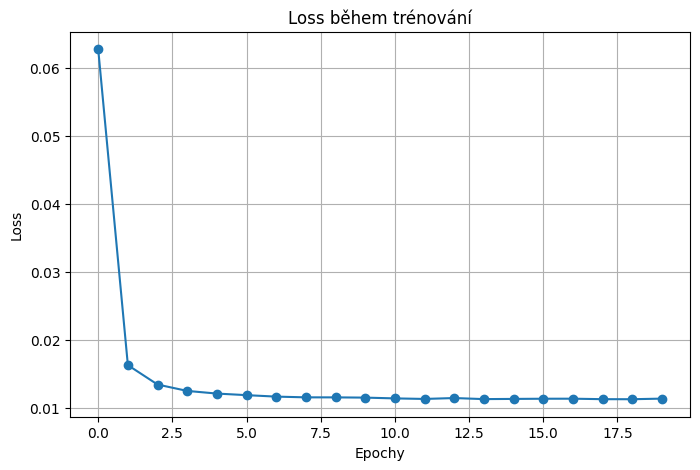


✅ Training finished!


In [ ]:
#@title Spuštění Res-U-Net
"""
Runs Res-U-Net training with specified parameters.
"""
DATASET_LENGTH = 4000
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
model_resunet = train_experiment(DATASET_LENGTH, BATCH_SIZE, EPOCHS, LEARNING_RATE)

In [ ]:
#@title Stažení

from google.colab import files
torch.save(model_resunet.state_dict(), "resunet_trained.pth")
files.download("resunet_trained.pth")
files.download("loss_history_resunet.pdf")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>